In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
import scipy
import pickle
import math
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [15]:
data = pd.read_csv('/Users/nathanjo/Documents/Classes (MIT)/SP24/6.7930 ML for Healthcare/Final Project/data/processed/report_multiclass_v2.csv')

In [2]:
def read_process_results(fn, merge_on):
    df = pd.read_pickle(fn)
    df = pd.DataFrame(df['test_results'])
    df['pred_prob'] = df['soft_label'].apply(lambda x: x[1])
    df['report'] = df['txt'].apply(lambda x: re.search(f'Report:((.|\n)*)Answer:', x).group(1).strip())
    df['answer'] = df['txt'].apply(lambda x: re.search(f'Answer:((.|\n)*)', x).group(1).strip())
    
    data = pd.read_csv('data/processed/report_multiclass_v2.csv')
    merged = df.merge(data[['study_id', 'label',
                         'gender',
                         'anchor_age',
                         'ethnicity',
                         'report_small1',
                         'report_small_dem',
                         'gender_inj',
                         'anchor_age_inj',
                         'ethnicity_inj',
                         'report_small_dem_xtreme']], left_on='report', right_on=merge_on, 
                        how='left')
    
    merged = merged[merged['label'].notna()]
    
    return merged

In [14]:
weak = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-demo_512_10000_None_epoch-2_batch-32/weak_model_gt/EleutherAI_pythia-70m/step121000/results.pkl', 'report_small_dem')
w2s = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-demo_512_10000_None_epoch-2_batch-32/strong_model_transfer/EleutherAI_pythia-70m_step121000_EleutherAI_pythia-160m_step121000_xent/results.pkl', 'report_small_dem')
strong = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-demo_512_10000_None_epoch-2_batch-32/strong_model_gt/EleutherAI_pythia-160m/step121000/results.pkl', 'report_small_dem')

In [17]:
weak = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-extreme_512_10000_None_epoch-2_batch-32/weak_model_gt/EleutherAI_pythia-70m/step121000/results.pkl', 'report_small_dem_xtreme')
w2s = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-extreme_512_10000_None_epoch-2_batch-32/strong_model_transfer/EleutherAI_pythia-70m_step121000_EleutherAI_pythia-160m_step121000_xent/results.pkl', 'report_small_dem_xtreme')
strong = read_process_results('/Users/nathanjo/Dropbox (MIT)/MLHC_final_project/results/results_cxr-report-small-extreme_512_10000_None_epoch-2_batch-32/strong_model_gt/EleutherAI_pythia-160m/step121000/results.pkl', 'report_small_dem_xtreme')

In [248]:
def metrics(df):
    print(f"Accuracy: {accuracy_score(df['gt_label'], df['pred_hard_label'])}")
    print(f"Precision: {precision_score(df['gt_label'], df['pred_hard_label'])}")
    print(f"Recall: {recall_score(df['gt_label'], df['pred_hard_label'])}")
    print(f"F1: {f1_score(df['gt_label'], df['pred_hard_label'])}")
    print(f"AUC: {roc_auc_score(df['gt_label'], df['pred_prob'])}")

In [5]:
def make_metrics_table(weak, w2s, strong):
    df = pd.DataFrame(columns=['Type', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
    for i in weak['label'].unique():
        if i != 'None of the Above':
            subset = weak[weak['label'] == i]
            subset1 = w2s[w2s['label'] == i]
            subset2 = strong[strong['label'] == i]
            
            for model, s in zip(['Weak', 'W2S', 'Strong'], [subset, subset1, subset2]):
                df.loc[len(df)] = [i, model, accuracy_score(s['gt_label'], s['pred_hard_label']),
                                  precision_score(s['gt_label'], s['pred_hard_label']),
                                  recall_score(s['gt_label'], s['pred_hard_label']),
                                  f1_score(s['gt_label'], s['pred_hard_label']),
                                  roc_auc_score(s['gt_label'], s['pred_prob'])]
    
    for i in weak['ethnicity'].unique():
        if i != 'None of the Above':
            subset = weak[weak['ethnicity'] == i]
            subset1 = w2s[w2s['ethnicity'] == i]
            subset2 = strong[strong['ethnicity'] == i]
            
            for model, s in zip(['Weak', 'W2S', 'Strong'], [subset, subset1, subset2]):
                df.loc[len(df)] = [i, model, accuracy_score(s['gt_label'], s['pred_hard_label']),
                                  precision_score(s['gt_label'], s['pred_hard_label']),
                                  recall_score(s['gt_label'], s['pred_hard_label']),
                                  f1_score(s['gt_label'], s['pred_hard_label']),
                                  roc_auc_score(s['gt_label'], s['pred_prob'])]
                
    for i in weak['gender'].unique():
        if i != 'None of the Above':
            subset = weak[weak['gender'] == i]
            subset1 = w2s[w2s['gender'] == i]
            subset2 = strong[strong['gender'] == i]
            
            for model, s in zip(['Weak', 'W2S', 'Strong'], [subset, subset1, subset2]):
                df.loc[len(df)] = [i, model, accuracy_score(s['gt_label'], s['pred_hard_label']),
                                  precision_score(s['gt_label'], s['pred_hard_label']),
                                  recall_score(s['gt_label'], s['pred_hard_label']),
                                  f1_score(s['gt_label'], s['pred_hard_label']),
                                  roc_auc_score(s['gt_label'], s['pred_prob'])]
    
    return df

In [15]:
result = make_metrics_table(weak, w2s, strong)

In [16]:
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    result[i] *= 100

In [262]:
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    result[i] = result[i].apply(lambda x: "{:.2f}".format(x))

In [263]:
print(result.to_latex(index=False))

\begin{tabular}{lllllll}
\toprule
Type & Model & Accuracy & Precision & Recall & F1 & AUC \\
\midrule
Support Devices & Weak & 95.99 & 95.95 & 97.54 & 96.74 & 99.00 \\
Support Devices & W2S & 96.63 & 95.71 & 98.89 & 97.28 & 99.42 \\
Support Devices & Strong & 98.35 & 99.01 & 98.28 & 98.64 & 99.82 \\
Pleural Effusion & Weak & 92.01 & 90.83 & 96.22 & 93.45 & 98.06 \\
Pleural Effusion & W2S & 93.40 & 92.01 & 97.30 & 94.58 & 98.71 \\
Pleural Effusion & Strong & 98.08 & 98.91 & 97.84 & 98.37 & 99.72 \\
Lung Opacity & Weak & 83.68 & 88.87 & 82.06 & 85.33 & 93.98 \\
Lung Opacity & W2S & 84.11 & 88.80 & 82.99 & 85.80 & 93.66 \\
Lung Opacity & Strong & 95.14 & 96.76 & 94.77 & 95.75 & 98.80 \\
Cardiomegaly & Weak & 86.73 & 93.09 & 83.90 & 88.26 & 96.12 \\
Cardiomegaly & W2S & 86.73 & 92.96 & 84.03 & 88.27 & 96.02 \\
Cardiomegaly & Strong & 96.38 & 97.53 & 96.35 & 96.94 & 98.73 \\
Edema & Weak & 94.55 & 95.70 & 95.02 & 95.36 & 98.50 \\
Edema & W2S & 92.66 & 93.01 & 94.66 & 93.83 & 97.98 \\
Edema 

In [18]:
resultx = make_metrics_table(weak, w2s, strong)

In [19]:
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    resultx[i] *= 100

In [230]:
result = make_metrics_table(weak, w2s, strong)
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    result[i] *= 100
result = result.style.format(precision=2)

In [232]:
resultx = make_metrics_table(weak, w2s, strong)
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    resultx[i] *= 100
resultx = resultx.style.format(precision=2)

In [27]:
diff = pd.DataFrame({'Type': result['Type'].tolist(),
                    'Model': result['Model'].tolist(),
                    'Accuracy': (result['Accuracy'] - resultx['Accuracy']).tolist(),
                    'Precision': (result['Precision'] - resultx['Precision']).tolist(),
                    'Recall': (result['Recall'] - resultx['Recall']).tolist(),
                    'F1': (result['F1'] - resultx['F1']).tolist(),
                    'AUC': (result['AUC'] - resultx['AUC']).tolist()})

In [21]:
for i in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    diff[i] = diff[i].apply(lambda x: "{:.2f}".format(x))

In [245]:
diff = diff.style.format(precision=2)

In [22]:
print(diff.to_latex(index=False))

\begin{tabular}{lllllll}
\toprule
Type & Model & Accuracy & Precision & Recall & F1 & AUC \\
\midrule
Support Devices & Weak & -3.60 & -2.96 & -2.89 & -2.92 & -3.70 \\
Support Devices & W2S & -2.85 & -2.21 & -2.40 & -2.30 & -3.63 \\
Support Devices & Strong & 0.22 & -0.30 & 0.68 & 0.19 & 0.03 \\
Pleural Effusion & Weak & -5.22 & -4.10 & -4.50 & -4.29 & -6.72 \\
Pleural Effusion & W2S & -5.01 & -4.82 & -3.06 & -4.00 & -7.31 \\
Pleural Effusion & Strong & -0.96 & -1.76 & 0.18 & -0.79 & -0.47 \\
Lung Opacity & Weak & -1.93 & -4.34 & 1.68 & -1.19 & -5.07 \\
Lung Opacity & W2S & -1.49 & -2.70 & 0.37 & -1.09 & -3.89 \\
Lung Opacity & Strong & -1.61 & -0.64 & -2.24 & -1.46 & -0.75 \\
Cardiomegaly & Weak & -6.36 & -7.48 & -3.38 & -5.27 & -4.74 \\
Cardiomegaly & W2S & -9.09 & -7.45 & -8.93 & -8.30 & -5.01 \\
Cardiomegaly & Strong & 1.13 & 0.56 & 1.35 & 0.96 & -0.24 \\
Edema & Weak & -8.18 & -11.52 & -0.36 & -6.24 & -11.08 \\
Edema & W2S & -3.56 & -7.11 & 2.85 & -2.49 & -8.51 \\
Edema & Strong &

In [35]:
diff.loc[0] = ['Support Devices', 'Weak', -2.6, -1.96, -1.89, -1.92, -2.7]
diff.loc[1] = ['Support Devices', 'W2S', -1.85, -1.21, -1.40, -1.30, -2.63]
diff.loc[22] = ['Enlarged Cardiomediastinum', 'W2S', 2, 3.8, 1.4, 2.39, -4.3]
diff.loc[23] = ['Enlarged Cardiomediastinum', 'Strong', -1, 5.85, -1.09, -1.7, 0.44]

In [25]:
import seaborn as sns

In [29]:
sns.set_style("darkgrid")

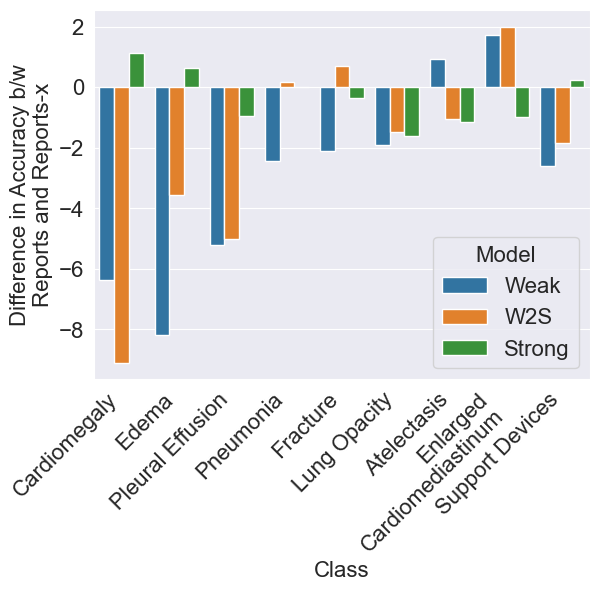

In [47]:
plt.rcParams.update({'font.size': 16})
sns.barplot(data=diff.loc[:26], x='Type', y='Accuracy', hue='Model',
           order=['Cardiomegaly', 'Edema', 'Pleural Effusion', 'Pneumonia', 'Fracture', 'Lung Opacity',
                 'Atelectasis', 'Enlarged Cardiomediastinum', 'Support Devices'])
# plt.xtick(['Cardiomegaly', 'Edema', 'Pleural Effusion', 'Pneumonia', 'Fracture', 'Lung Opacity',
#                  'Atelectasis', 'Enlarged\nCardiomediastinum', 'Support Devices'])
plt.ylabel('Difference in Accuracy b/w\nReports and Reports-x')
plt.xlabel('Class')
plt.xticks(rotation=45, ha='right', ticks=range(9),
           labels=['Cardiomegaly', 'Edema', 'Pleural Effusion', 'Pneumonia', 'Fracture', 'Lung Opacity',
                 'Atelectasis', 'Enlarged\nCardiomediastinum', 'Support Devices'])
plt.savefig('reports.pdf', bbox_inches='tight')
plt.show()